<a href="https://colab.research.google.com/github/SRINIDHISAGI/Mini_Transformer_Encoder/blob/main/Mini_Transformer_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Input token IDs:
 tensor([[35,  8, 31, 24, 35, 19,  0],
        [35, 12,  9, 35,  8,  0,  0],
        [35, 22,  5, 10,  0,  0,  0],
        [ 2,  8,  3,  2, 12,  4, 15],
        [37, 38, 32,  6,  0,  0,  0],
        [30, 21, 26, 33,  0,  0,  0],
        [ 6,  7, 18, 28, 29,  0,  0],
        [39, 34, 23, 16, 27,  0,  0],
        [20, 36, 13, 14,  0,  0,  0],
        [11, 17, 21,  4, 25,  0,  0]])

Token strings for first sentence:
['the', 'cat', 'sat', 'on', 'the', 'mat', '<pad>']

Final contextual embeddings shape: torch.Size([10, 7, 64])
Example embedding for first sentence, first token:
 tensor([ 0.4380, -0.1011, -0.3501,  1.4947, -0.9135, -0.7851, -0.4859, -0.3428,
         1.8360, -0.0490, -1.5397,  2.1560, -1.0734,  0.9672, -0.1235,  0.0920,
        -0.4286, -0.2368, -1.8630,  0.5900,  0.4056,  0.5174, -0.7976, -1.2499,
         0.6126, -0.5587,  0.2043,  1.3402,  0.1761,  0.2357,  0.0203, -0.4364,
        -0.8480,  0.6986, -0.4773,  0.2210, -0.2641,  2.8809, -0.8785,  0.6527,
   

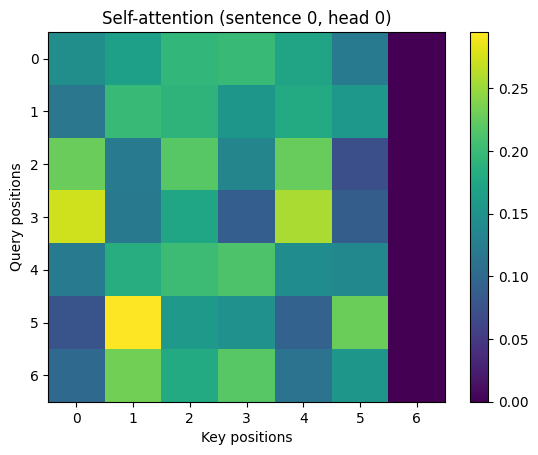

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ------------------------------
# 1. Toy dataset & tokenization
# ------------------------------

sentences = [
    "the cat sat on the mat",
    "the dog chased the cat",
    "the mouse ate cheese",
    "a cat and a dog are friends",
    "transformers use self attention",
    "rnn models process sequences",
    "attention captures long range relations",
    "we study natural language processing",
    "mini transformer encoder example",
    "deep learning models are powerful",
]

def tokenize(sent):
    return sent.lower().split()


# Build vocab
tokens = []
for s in sentences:
    tokens.extend(tokenize(s))

vocab = sorted(set(tokens))
stoi = {w: i + 2 for i, w in enumerate(vocab)}  # reserve 0=PAD, 1=UNK
stoi["<pad>"] = 0
stoi["<unk>"] = 1
itos = {i: w for w, i in stoi.items()}

max_len = max(len(tokenize(s)) for s in sentences)


def encode_sentence(s):
    toks = tokenize(s)
    ids = [stoi.get(t, 1) for t in toks]
    # pad to max_len
    ids += [0] * (max_len - len(ids))
    return ids


batch_ids = torch.tensor([encode_sentence(s) for s in sentences], dtype=torch.long, device=device)
# Shape: (B, T)
B, T = batch_ids.shape


# ------------------------------
# 2. Positional encoding
# ------------------------------

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x):
        # x: (B, T, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return x


# ------------------------------
# 3. Scaled dot-product attention
# ------------------------------

def scaled_dot_product_attention(Q, K, V, mask=None):
    # Q,K,V: (B, heads, T, d_k)
    scores = Q @ K.transpose(-2, -1) / math.sqrt(Q.size(-1))  # (B, heads, T, T)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float("-inf"))
    attn = F.softmax(scores, dim=-1)
    out = attn @ V  # (B, heads, T, d_k)
    return out, attn


# ------------------------------
# 4. Multi-head attention
# ------------------------------

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model=64, num_heads=4):
        super().__init__()
        assert d_model % num_heads == 0
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        B, T, D = x.shape
        H = self.num_heads
        d_k = self.d_k

        Q = self.W_q(x)  # (B, T, D)
        K = self.W_k(x)
        V = self.W_v(x)

        # reshape to (B, H, T, d_k)
        Q = Q.view(B, T, H, d_k).transpose(1, 2)
        K = K.view(B, T, H, d_k).transpose(1, 2)
        V = V.view(B, T, H, d_k).transpose(1, 2)

        out, attn = scaled_dot_product_attention(Q, K, V, mask=mask)
        # (B, H, T, d_k) -> (B, T, D)
        out = out.transpose(1, 2).contiguous().view(B, T, D)
        out = self.W_o(out)
        return out, attn  # attn: (B, H, T, T)


# ------------------------------
# 5. Feed-forward + Encoder layer
# ------------------------------

class FeedForward(nn.Module):
    def __init__(self, d_model=64, d_ff=256, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


class EncoderLayer(nn.Module):
    def __init__(self, d_model=64, num_heads=4, d_ff=256, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadSelfAttention(d_model, num_heads)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self-attention
        attn_out, attn_weights = self.self_attn(x, mask=mask)
        x = self.norm1(x + self.dropout(attn_out))

        # Feed-forward
        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout(ff_out))

        return x, attn_weights


# ------------------------------
# 6. Full encoder
# ------------------------------

class MiniTransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model=64, num_heads=4, num_layers=1, max_len=50):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len=max_len)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads=num_heads) for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        # x: (B, T)
        x = self.embed(x)
        x = self.pos_enc(x)

        attn_maps = []
        for layer in self.layers:
            x, attn = layer(x, mask=mask)
            attn_maps.append(attn)
        return x, attn_maps


def main():
    vocab_size = len(stoi)
    model = MiniTransformerEncoder(vocab_size=vocab_size, d_model=64,
                                   num_heads=4, num_layers=1,
                                   max_len=max_len).to(device)

    mask = (batch_ids != 0).unsqueeze(1).unsqueeze(2)  # (B, 1, 1, T) for padding

    with torch.no_grad():
        contextual, attn_maps = model(batch_ids, mask=mask)

    print("Input token IDs:\n", batch_ids)
    print("\nToken strings for first sentence:")
    print([itos[i.item()] for i in batch_ids[0]])

    print("\nFinal contextual embeddings shape:", contextual.shape)
    print("Example embedding for first sentence, first token:\n", contextual[0, 0])

    # Attention map for first layer, first head, first sentence
    attn = attn_maps[0]  # (B, H, T, T)
    attn_example = attn[0, 0]  # (T, T)
    print("\nAttention weights (sentence 0, head 0):\n", attn_example)

    # Optional: visualize as heatmap
    plt.figure()
    plt.imshow(attn_example.cpu().numpy(), aspect="auto")
    plt.colorbar()
    plt.title("Self-attention (sentence 0, head 0)")
    plt.xlabel("Key positions")
    plt.ylabel("Query positions")
    plt.show()


if __name__ == "__main__":
    main()
